In [1]:
import numpy as np
import cupy as cp
import cupy.linalg
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import *
import time
import skimage.io

In [2]:
# Standard K-Means implementation

def CPU_clusters(centroids, K, X):
    clusters = [[] for i in range(K)]
    for idx, sample in enumerate(X):
        distances = np.empty(K)
        # Calculating the distance between the sample and each centroid
        distances = [np.linalg.norm(centroids[i] - sample) for i in range(K)]
        # Finding the closest centroid
        centroid_idx = np.argmin(distances)
        # Creating a cluster by assigning samples to the closest centroid
        clusters[centroid_idx].append(idx)
    return clusters

# Returns new centroids of the clusters after computing the means
def CPU_means(clusters, K, X):
  n = np.shape(X)[1]
  centroids = np.empty((K, n))
  for cluster_idx, cluster in enumerate(clusters):
    centroids[cluster_idx] = np.mean(X[cluster], axis=0)
  return centroids

# Assigning a label to each sample
# where the label represents the cluster the sample was assigned to
def CPU_labels(clusters, X):
    labels = np.empty(np.shape(X)[0])
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    return labels

In [3]:
def CPU_KMeans(X, K, max_iters):
    m, n = np.shape(X)
    centroids = np.empty((K, n))
    # Initialize centroids by picking K random samples from the image
    for i in range(K):
        centroids[i] = X[np.random.choice(range(m))]
    for i in range(max_iters):
        # Create clusters
        clusters = CPU_clusters(centroids, K, X)
        prev_centroids = centroids
        # Find new centroids by computing the means of each cluster
        centroids = CPU_means(clusters, K, X)
        # Check if the centroids have changed
        change = prev_centroids - centroids
        if not change.any():
            break # Exit the loop if they've stayed the same
        return CPU_labels(clusters, X), centroids


In [17]:
url = "http://sipi.usc.edu/database/preview/misc/5.3.02.png"
img = skimage.io.imread(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
K = 3 # Number of clusters
attempts=100 # Number of iterations

In [18]:
pixel_values = img.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

start_time = time.time()
y_pred, centroids = CPU_KMeans(pixel_values, K, attempts)
cpu_time = time.time() - start_time
print(f"CPU execution time: {cpu_time} seconds")


CPU execution time: 0.6738908290863037 seconds


In [19]:
# Visualizing the results

centers = np.uint8(centroids)
y_pred = y_pred.astype(int)
np.unique(y_pred)
labels = y_pred.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(img.shape)
#plt.imshow(segmented_image)
#plt.show()

In [24]:
# Since CUDA's array initialization is noticeably slower, the above code's
# runtime will be longer if we simply replace numpy with cupy (as shown at the end)
# the solution is implemented with cupy.get_array_module() instead


# Parallel realization
def GPU_KMeans(X, K, max_iter):
    xp = cupy.get_array_module(X)
    m, n = cp.shape(X)
    X = cupy.asarray(X)
    labels = xp.zeros(len(X))
    centroids = cp.empty((K, n))
    # Initialize centroids by picking K random samples from the image
    x = cp.random.choice(range(m), K, replace=False)
    centroids = X[x]
    for i in range(max_iter):
        # Finding labels for each sample
        distances = xp.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
        new_labels = xp.argmin(distances, axis=1)
        if xp.all(new_labels == labels):
            break # Exit the loop if none of the labels have changed
        labels = new_labels
        i = xp.arange(K)
        # Finding new centroids for each cluster
        mask = labels == i[:, None]
        sums = xp.where(mask[:, :, None], X, 0).sum(axis=1)
        counts = xp.count_nonzero(mask, axis=1).reshape((K, 1))
        centroids = sums / counts
    return centroids, labels

In [20]:
imgGPU = cp.asarray(img)
pixel_values = cp.reshape(imgGPU, (-1, 3))
pixel_values = pixel_values.astype(cp.float32)


start_time = time.time()
centroids, y_pred = GPU_KMeans(pixel_values, K, attempts)
gpu_time = time.time() - start_time
print(f"GPU execution time: {gpu_time} seconds")

GPU execution time: 0.02680230140686035 seconds


In [21]:
# Visualizing the results

centroids = cp.asarray(centroids)
centers = centroids.astype(cp.uint8)
y_pred = y_pred.astype(int)
cp.unique(y_pred)
labels = y_pred.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(img.shape)
#plt.imshow(cp.asnumpy(segmented_image))
#plt.show()

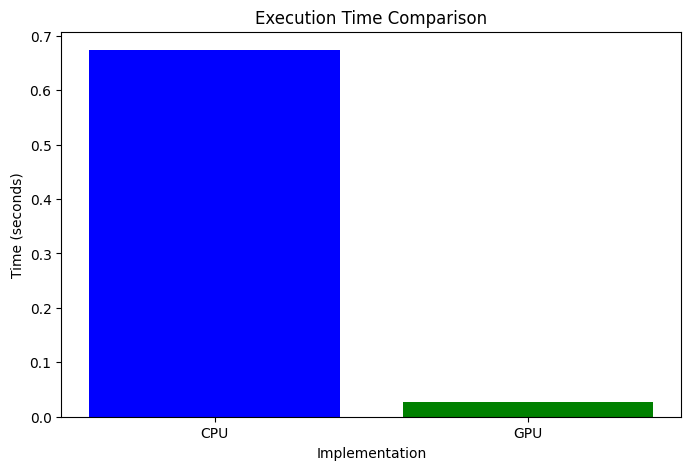

In [22]:
labels = ['CPU', 'GPU']
times = [cpu_time, gpu_time]

plt.figure(figsize=(8, 5))
plt.bar(labels, times, color=['blue', 'green'])
plt.title('Execution Time Comparison')
plt.xlabel('Implementation')
plt.ylabel('Time (seconds)')
plt.show()

In [11]:
# The slower variant where numpy is replaced with cupy
def GPU_clusters(centroids, K, X):
    clusters = [[] for i in range(K)]
    for idx, sample in enumerate(X):
        distances = [cp.linalg.norm(centroids[i] - sample) for i in range(K)]
        distances = cp.asarray(distances)
        centroid_idx = cp.argmin(distances)
        centroid_idx = int(centroid_idx)
        clusters[centroid_idx].append(idx)
    return clusters

def GPU_means(clusters, K, X):
    n = cp.shape(X)[1]
    centroids = cp.empty((K, n))
    for cluster_idx, cluster in enumerate(clusters):
        centroids[cluster_idx] = cp.mean(X[cluster], axis=0)
    return centroids

def GPU_labels(clusters, X):
    labels = cp.empty(cp.shape(X)[0])
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    return labels

def slowerGPU_KMeans(X, K, max_iters):
    # initializing centroids
    m, n = cp.shape(X)
    centroids = cp.empty((K, n))
    for i in range(K):
        x = cp.random.choice(range(m), K, replace=False)
        x = int(x[0])
        centroids[int(i)] = X[x]
    centroids = centroids.astype(cp.float32)
    clusters = [[] for i in range(K)]
    distances = cp.empty(K)
    for i in range(max_iters):
        clusters = GPU_clusters(centroids, K, X)
        prev_centroids = centroids
        centroids = GPU_means(clusters, K, X)
        change = prev_centroids - centroids
        if not change.any():
            break
            #return GPU_labels(clusters, X), centroids
        return GPU_labels(clusters, X), centroids

In [23]:
imgGPU = cp.asarray(img)
pixel_values = cp.reshape(imgGPU, (-1, 3))
pixel_values = pixel_values.astype(cp.float32)

GPU_shape = pixel_values.shape
start_time = time.time()
y_pred, centroids = slowerGPU_KMeans(pixel_values, K, attempts)
gpu_time = time.time() - start_time

# Visualizing results
centroids = cp.asarray(centroids)
centers = centroids.astype(cp.uint8)
y_pred = y_pred.astype(int)
cp.unique(y_pred)
labels = y_pred.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(img.shape)
#plt.imshow(cp.asnumpy(segmented_image))
#plt.show()

print(f"GPU execution time: {gpu_time} seconds")

GPU execution time: 19.041943311691284 seconds
